# Test thresholds for CAM binarization and Pattern Mining

Try all classical thresholds from skimage to detect points that are relevant for classification in CAMs. Stripes of
relevant points are then used for pattern mining.


#### Imports and functions definitions

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from load_data import DataProcesser
from results_model import top_classification_perclass
from pattern_utils import BinarizedCam, extend_bin, longest_strides
from class_dataset import myDataset, ToTensor, RandomCrop
from dtaidistance import dtw, clustering
from models import ConvNetCam
import matplotlib.pyplot as plt
from pattern_utils import create_cam
from skimage.filters import threshold_isodata, threshold_li, threshold_mean, threshold_minimum,\
    threshold_otsu, threshold_triangle, threshold_yen


def all_threshs(x):
    iso = threshold_isodata(x)
    li = threshold_li(x)
    mean = threshold_mean(x)
    mini = threshold_minimum(x)
    otsu = threshold_otsu(x)
    tri = threshold_triangle(x)
    yen = threshold_yen(x)
    return {'isodata': iso, 'li': li, 'mean': mean, 'minimum': mini, 'otsu': otsu, 'triangle': tri, 'yen': yen}


def both_cams(id_traj, patt_percmax_cam=0.5):
    series_numpy = np.array(df.loc[df['ID'] == id_traj]['Value']).astype('float')
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    bincam = BinarizedCam(model, array_series=series_tensor, percmax=patt_percmax_cam,
                          target_class=class_trajectory, device=device, clip=0)
    thresh = np.max(cam) * patt_percmax_cam
    return cam, bincam, thresh, series_numpy


def thresh_plot(xtupl, threshs, title):
    plt.close()
    plt.figure(figsize=(8,10), dpi=90)
    ax = plt.subplot(5,2,1)
    plt.hist(xtupl[0])
    plt.axvline(xtupl[2], linestyle='--', color='r')
    ax.set_xticklabels([])
    plt.title('Histogram of raw CAM')
    ax = plt.subplot(5,2,2)
    plt.plot(np.arange(len(xtupl[3])), xtupl[3])
    plt.scatter(np.arange(len(xtupl[3])), xtupl[3], c=xtupl[1])
    ax.set_xticklabels([])
    plt.title('Perc of max CAM')
    iplot = 3
    for thresh in threshs:
        binarized = np.where(xtupl[0] >= threshs[thresh], 1, 0)
        ax = plt.subplot(5,2,iplot)
        plt.plot(np.arange(len(xtupl[3])), xtupl[3])
        plt.scatter(np.arange(len(xtupl[3])), xtupl[3], c=binarized)
        if iplot != 9:
            ax.set_xticklabels([])
        plt.title(thresh)
        iplot += 1
    ax = plt.subplot(5,2,10)
    plt.annotate(title, xy=(0.5, 0.5), xycoords='axes fraction')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


## With synthetic data (2 first classes, mixtures of Gaussians without 2nd channel)

In [2]:
data_file = '../data/synthetic_len750.zip'
model_file = '../models/FRST_classAB/2019-06-04-18:06:45_synthetic_len750.pytorch'
selected_set = 'both'
meas_var = ['FRST']

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
model = torch.load(model_file)
model.eval()
model.double()
model.batch_size = 1
model = model.to(device)

data = DataProcesser(data_file)
data.subset(sel_groups=meas_var, start_time=0, end_time=750)
data.get_stats()
data.dataset = data.dataset[data.dataset[data.col_class].isin([0,1])]
#data.process(method='center_train', independent_groups=True)  # do here and not in loader so can use in df
#data.crop_random(model.length, ignore_na_tails=True)
data.split_sets(which='dataset')
classes = tuple(data.classes.iloc[:, 1])
classes=('A', 'B')

# Random crop before to keep the same in df as the ones passed in the model
if selected_set == 'validation':
    selected_data = myDataset(dataset=data.validation_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                  ToTensor()]))
    df = data.validation_set
elif selected_set == 'training':
    selected_data = myDataset(dataset=data.train_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                  ToTensor()]))
    df = data.train_set
elif selected_set == 'both':
    try:
        selected_data = myDataset(dataset=data.dataset_cropped,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                      ToTensor()]))
        df = data.dataset_cropped
    except:
        selected_data = myDataset(dataset=data.dataset,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                      ToTensor()]))
        df = data.dataset

data_loader = DataLoader(dataset=selected_data,
                         batch_size=1,
                         shuffle=True,
                         num_workers=4)
# Dataframe used for retrieving trajectories
df.columns = ['ID', 'Class'] + [i+1 for i in range(len(df.columns)-2)]
df = df.melt(['ID', 'Class'])
df.rename(columns={'variable': 'Time', 'value': 'Value'}, inplace=True)
df['ID'] = df['ID'].astype('U32')
del data  # free memory

/home/marc/Dropbox/Work/TSclass_GF/load_data.py:426: UserWarning: Data were not processed.
  warnings.warn('Data were not processed.')


In [3]:
ids = ['A_2688', 'A_7540', 'A_7619', 'A_8594', 'B_1145', 'B_3652', 'B_6453', 'B_4460']
cams = {i:both_cams(i) for i in ids}

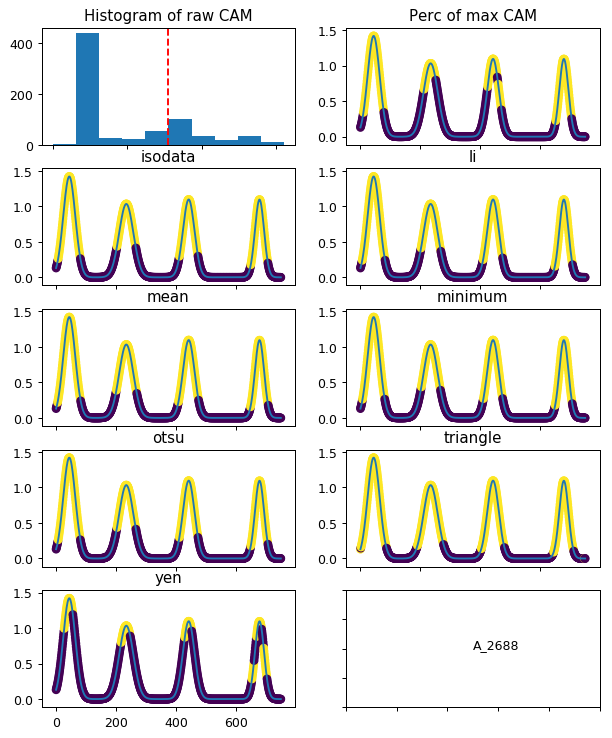

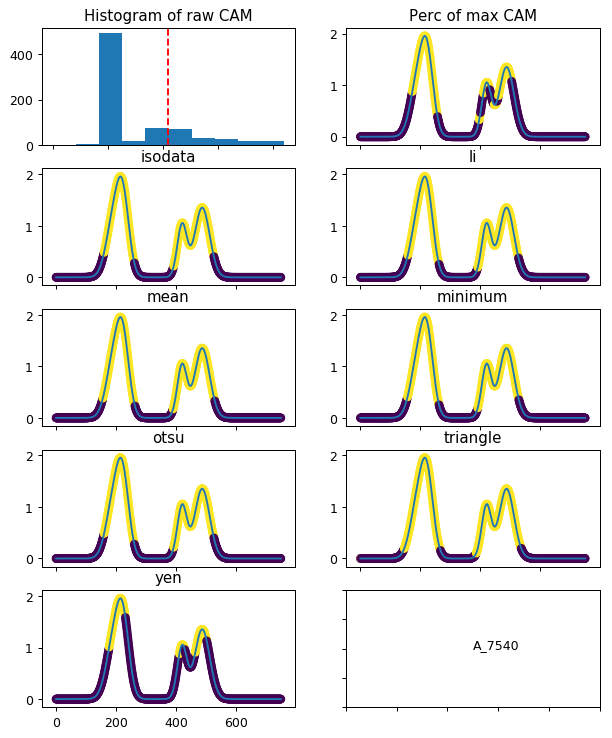

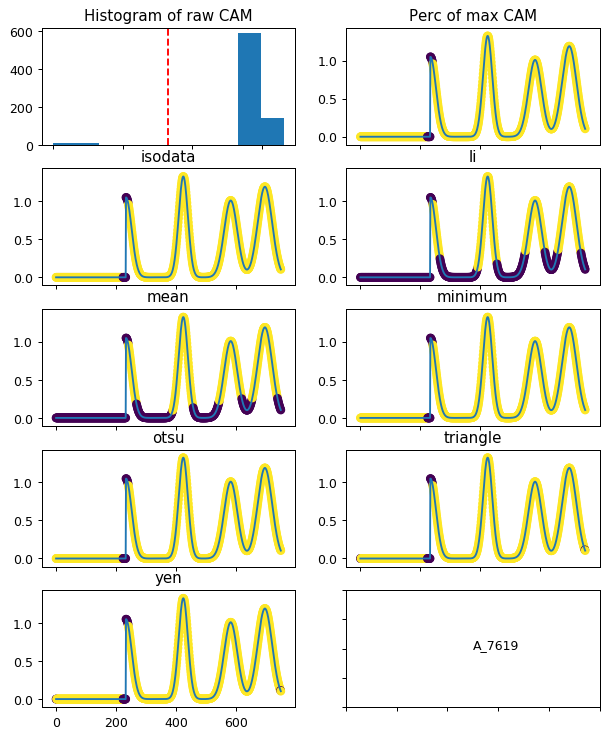

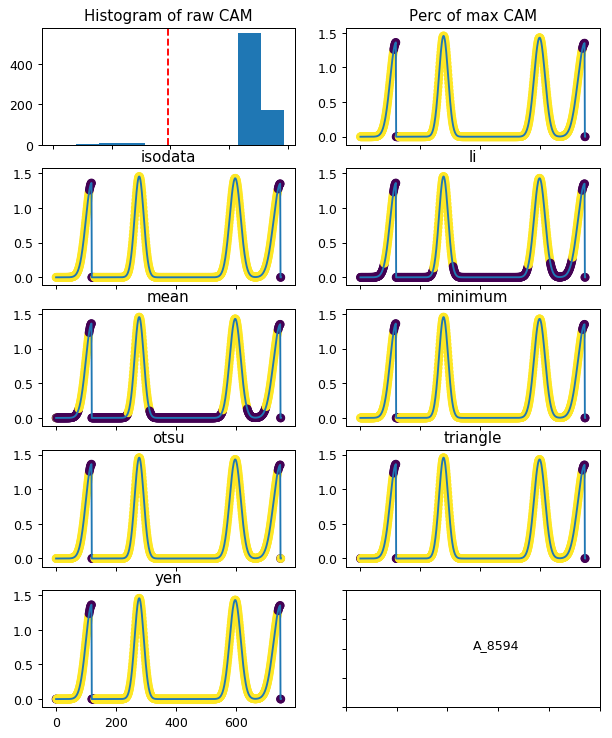

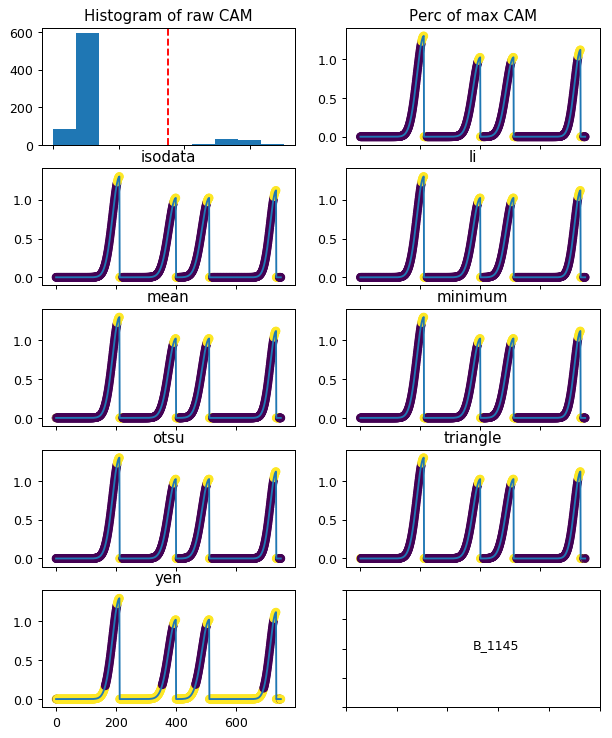

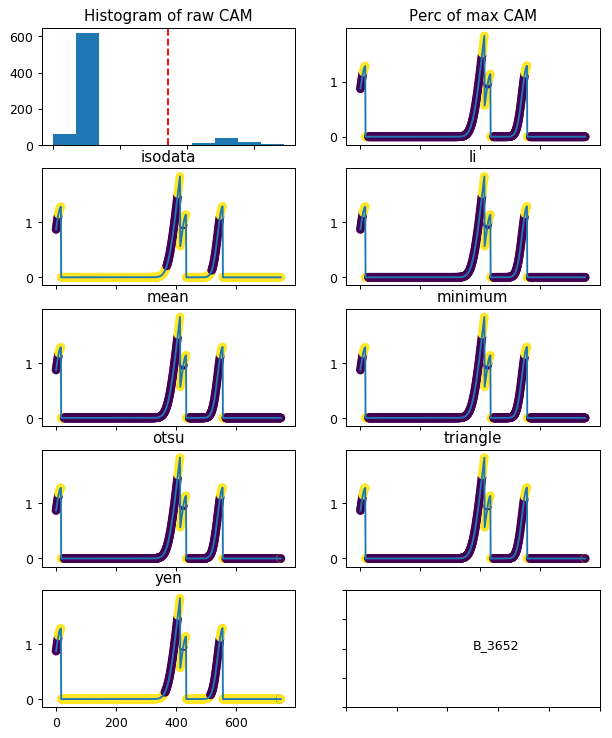

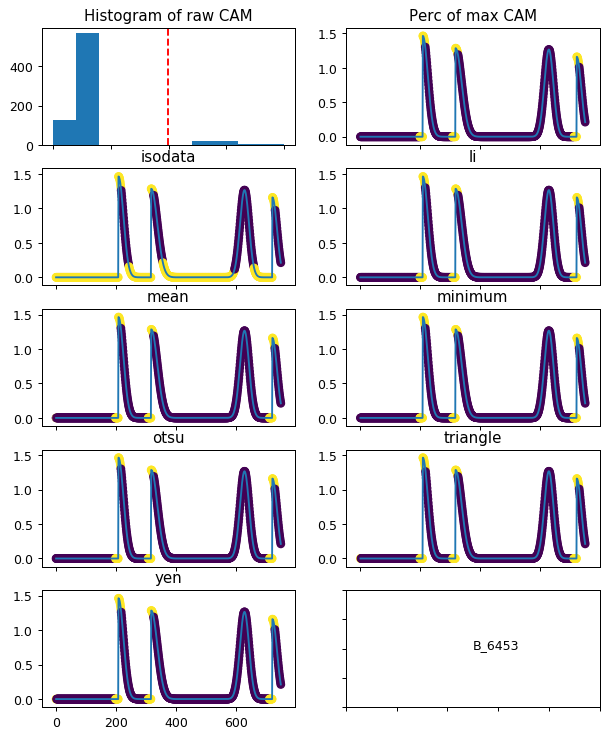

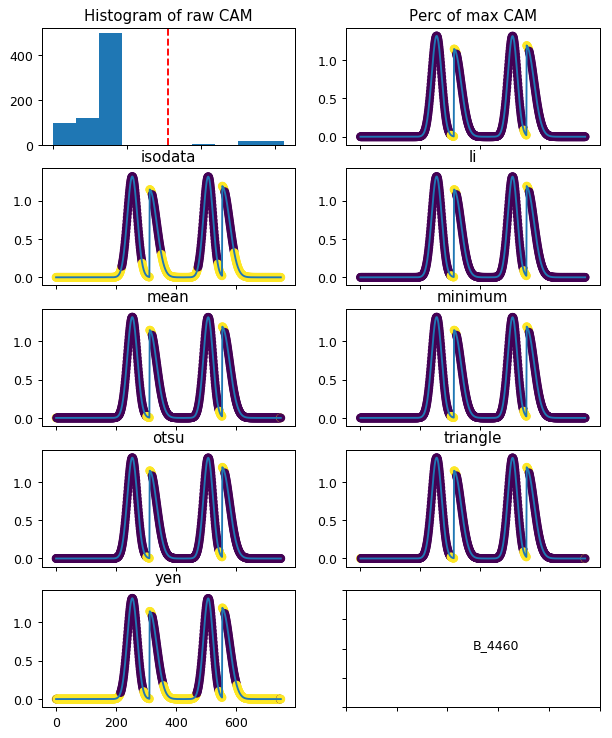

done here


In [4]:
for id in ids:
    thresh_plot(cams[id], all_threshs(cams[id][0]), id)
print('done here')

### Results

The thresholds li and mean appear most robust.